In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.set_printoptions(precision=6, linewidth=110)

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0, '../../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2 as f2
import gaussianprocessregression as gpr
import designofexperiment as doe
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics
import uncertaintysampling as us

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(f2)
imp.reload(gpr)
imp.reload(doe)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)
imp.reload(us)

import constants
imp.reload(constants)
from constants import *

# Plotting surrogate as function of waveform parameters

In [3]:
def plot_1d_amp_phase_variation(ax_amp, ax_phase, sur, params, xi, xlow, xhigh, nx, mfs, legend=True):
    """Plot amplitude(1parameter) and phase(1parameter) as the single parameter is varied.
    Do this for all the frequencies mfs.
    
    Parameters
    ----------
    params : 1d array
        Point in full parameter space where the 1d slice should pass through
    xi : int
        Index of the parameter you want to vary
    xlow, xhigh, nx : bounds and number of samples for the feature
    mfs : 1d array
        Frequencies at which to plot the 1d variation.
    """
    xs = np.linspace(xlow, xhigh, nx)
    ps = np.array([params for j in range(len(xs))])
    for j in range(len(xs)):
        ps[j, xi] = xs[j]
    
    dhs = [sur.amp_phase_difference(p) for p in ps]
    #dhs = [sur.geometric_waveform(p) for p in ps]
    
    amp_list = []
    phase_list = []
    for i in range(len(dhs)):
        amps = dhs[i].interpolate('amp')(mfs)
        phases = dhs[i].interpolate('phase')(mfs)
        amp_list.append(amps)
        phase_list.append(phases)
    amp_array = np.array(amp_list).T
    phase_array = np.array(phase_list).T
    
    for j in range(len(mfs)):
        ax_amp.plot(xs, amp_array[j], label=mfs[j])

    for j in range(len(mfs)):
        ax_phase.plot(xs, phase_array[j])
    
    if legend:
        ax_amp.legend(ncol=2, frameon=False)
        

def plot_all_1d_slices(sur, params, limits, labels, mfs, nx=20):
    """Plot amplitude(1parameter) and phase(1parameter) as the single parameter is varied.
    Repeat this for all parameters.
    
    Parameters
    ----------
    params : 1d array
        Point in full parameter space where the 1d slice should pass through
    xi : int
        Index of the parameter you want to vary
    xlow, xhigh, nx : bounds and number of samples for the feature
    mfs : 1d array
        Frequencies at which to plot the 1d variation.
    """
    nparams = len(limits)
    fig, ax = plt.subplots(2, nparams, figsize=(min(8*nparams, 20), 6), sharex='col', sharey='row')
    title = '{:.3}, {:.2}, {:.2}, {:.1f}, {:.1f}'.format(params[0], params[1], params[2], params[3], params[4])
    fig.suptitle(title)
    for xi in range(nparams):
        ax1 = ax[0, xi]
        ax2 = ax[1, xi]
        xlow = limits[xi, 0]
        xhigh = limits[xi, 1]
        if xi==0:
            legend = True
            ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
            ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
        else:
            legend = False
        plot_1d_amp_phase_variation(ax1, ax2, sur, params, xi, xlow, xhigh, nx, mfs, legend=legend)
        ax1.minorticks_on()
        ax2.minorticks_on()
        #ax1.xaxis.set_ticklabels([])
        ax2.set_xlabel(labels[xi])
        # Manually rotate every single label 
        for label in ax2.get_xticklabels():
            label.set_rotation(45) 
    fig.subplots_adjust(hspace=0.0, wspace=0.0)

# Load surrogate model

In [4]:
Bamp_filename = '../../data/teobtest40hz/B_amp_corners_lhd.hdf5'
Bphase_filename = '../../data/teobtest40hz/B_phase_corners_lhd.hdf5'
gp_amp_filename = '../../data/teobtest40hz/gp_amp_corners_lhd.hdf5'
gp_phase_filename = '../../data/teobtest40hz/gp_phase_corners_lhd.hdf5'
sur = surrogate.GPSurrogate.load(Bamp_filename, Bphase_filename, gp_amp_filename, gp_phase_filename)

# Bamp_filename = '../../data/teobtest40hz/B_amp_lhd_uncsamp.hdf5'
# Bphase_filename = '../../data/teobtest40hz/B_phase_lhd_uncsamp.hdf5'
# gp_amp_filename = '../../data/teobtest40hz/gp_amp_lhd_uncsamp.hdf5'
# gp_phase_filename = '../../data/teobtest40hz/gp_phase_lhd_uncsamp.hdf5'
# sur = surrogate.GPSurrogate.load(Bamp_filename, Bphase_filename, gp_amp_filename, gp_phase_filename)

(<matplotlib.figure.Figure at 0x1172342d0>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x117dc8490>,
  <matplotlib.axes._subplots.AxesSubplot at 0x117eaf610>))

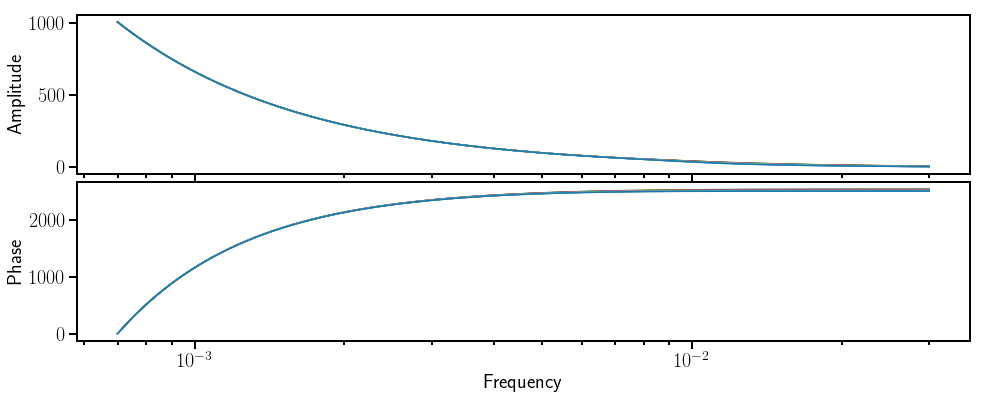

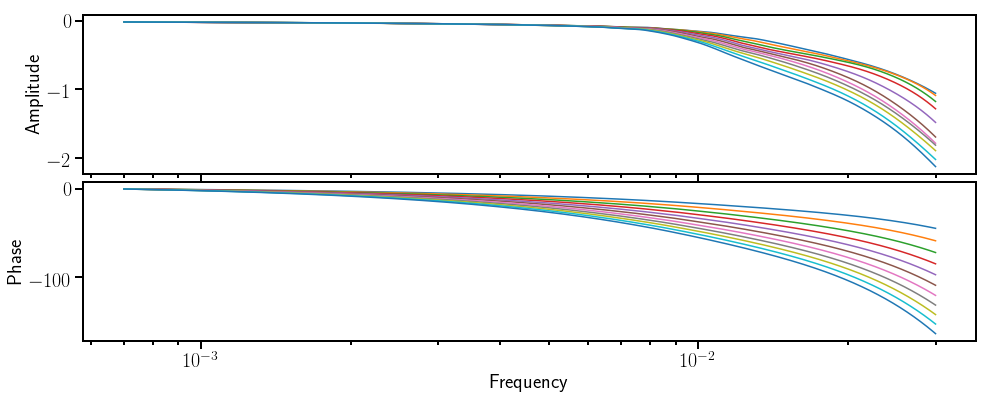

In [5]:
# Vary 1 parameters

q = 1.0
s1 = 0.3
s2 = 0.1
lambda1 = 1000.
lambda2 = 1000.
ps = np.array([[q, s1, s2, lambda1, lambda2] for lambda1 in np.linspace(0.1, 3000., 11)])

hs = [sur.geometric_waveform(p) for p in ps]
dhs = [sur.amp_phase_difference(p) for p in ps]

wave.plot_waveforms_fd(hs)
wave.plot_waveforms_fd(dhs)

# All 5 1d slices that pass through a specific point

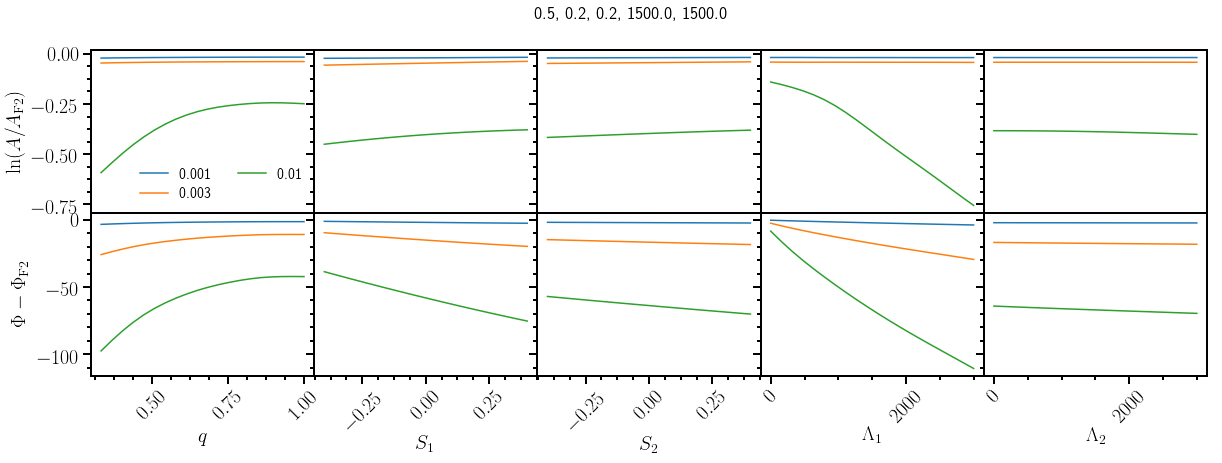

In [6]:
limits = np.array([[1.0/3.0, 1.0], [-0.4, 0.4], [-0.4, 0.4], [0.1, 3000], [0.1, 3000]])
labels = [r'$q$', r'$S_1$', r'$S_2$', r'$\Lambda_1$', r'$\Lambda_2$']
#mfs = np.array([0.001, 0.003, 0.01, 0.03])
mfs = np.array([0.001, 0.003, 0.01])
#mfs = np.array([0.001, 0.003])


# Average-ish values for each parameter
params = np.array([1.0/2.0, 0.2, 0.2, 1500, 1500])
plot_all_1d_slices(sur, params, limits, labels, mfs)

In [7]:
limits = np.array([[1.0/3.0, 1.0], [-0.4, 0.4], [-0.4, 0.4], [0.1, 3000], [0.1, 3000]])
labels = [r'$q$', r'$S_1$', r'$S_2$', r'$\Lambda_1$', r'$\Lambda_2$']
mfs = np.array([0.001, 0.003, 0.01])

def plots_on_corners():
    n = 2
    for i in range(n):
        xmin, xmax = limits[0, 0], limits[0, 1]
        x0 = np.linspace(xmin, xmax, n)
        for j in range(n):
            xmin, xmax = limits[1, 0], limits[1, 1]
            x1 = np.linspace(xmin, xmax, n)
            for k in range(n):
                xmin, xmax = limits[2, 0], limits[2, 1]
                x2 = np.linspace(xmin, xmax, n)
                for l in range(n):
                    xmin, xmax = limits[3, 0], limits[3, 1]
                    x3 = np.linspace(xmin, xmax, n)
                    for m in range(n):
                        xmin, xmax = limits[4, 0], limits[4, 1]
                        x4 = np.linspace(xmin, xmax, n)
                        
                        point = [x0[i], x1[j], x2[k], x3[l], x4[m]]
                        print point
                        plot_all_1d_slices(sur, point, limits, labels, mfs)

[0.33333333333333331, -0.40000000000000002, -0.40000000000000002, 0.10000000000000001, 0.10000000000000001]
[0.33333333333333331, -0.40000000000000002, -0.40000000000000002, 0.10000000000000001, 3000.0]
[0.33333333333333331, -0.40000000000000002, -0.40000000000000002, 3000.0, 0.10000000000000001]
[0.33333333333333331, -0.40000000000000002, -0.40000000000000002, 3000.0, 3000.0]
[0.33333333333333331, -0.40000000000000002, 0.40000000000000002, 0.10000000000000001, 0.10000000000000001]
[0.33333333333333331, -0.40000000000000002, 0.40000000000000002, 0.10000000000000001, 3000.0]
[0.33333333333333331, -0.40000000000000002, 0.40000000000000002, 3000.0, 0.10000000000000001]
[0.33333333333333331, -0.40000000000000002, 0.40000000000000002, 3000.0, 3000.0]
[0.33333333333333331, 0.40000000000000002, -0.40000000000000002, 0.10000000000000001, 0.10000000000000001]
[0.33333333333333331, 0.40000000000000002, -0.40000000000000002, 0.10000000000000001, 3000.0]
[0.33333333333333331, 0.40000000000000002, 

/Users/lackey/Library/Python/2.7/lib/python/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


[1.0, -0.40000000000000002, 0.40000000000000002, 0.10000000000000001, 3000.0]
[1.0, -0.40000000000000002, 0.40000000000000002, 3000.0, 0.10000000000000001]
[1.0, -0.40000000000000002, 0.40000000000000002, 3000.0, 3000.0]
[1.0, 0.40000000000000002, -0.40000000000000002, 0.10000000000000001, 0.10000000000000001]
[1.0, 0.40000000000000002, -0.40000000000000002, 0.10000000000000001, 3000.0]
[1.0, 0.40000000000000002, -0.40000000000000002, 3000.0, 0.10000000000000001]
[1.0, 0.40000000000000002, -0.40000000000000002, 3000.0, 3000.0]
[1.0, 0.40000000000000002, 0.40000000000000002, 0.10000000000000001, 0.10000000000000001]
[1.0, 0.40000000000000002, 0.40000000000000002, 0.10000000000000001, 3000.0]
[1.0, 0.40000000000000002, 0.40000000000000002, 3000.0, 0.10000000000000001]
[1.0, 0.40000000000000002, 0.40000000000000002, 3000.0, 3000.0]


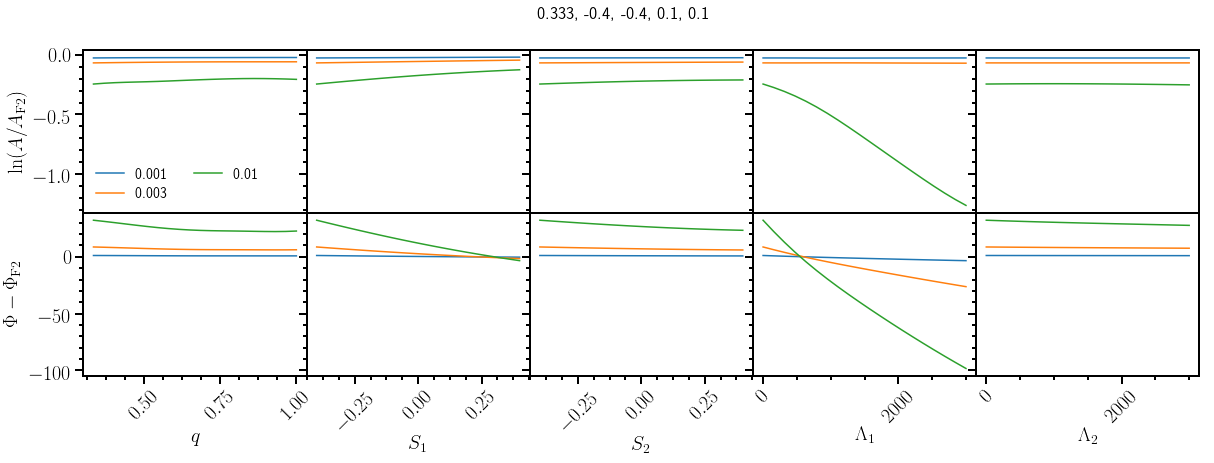

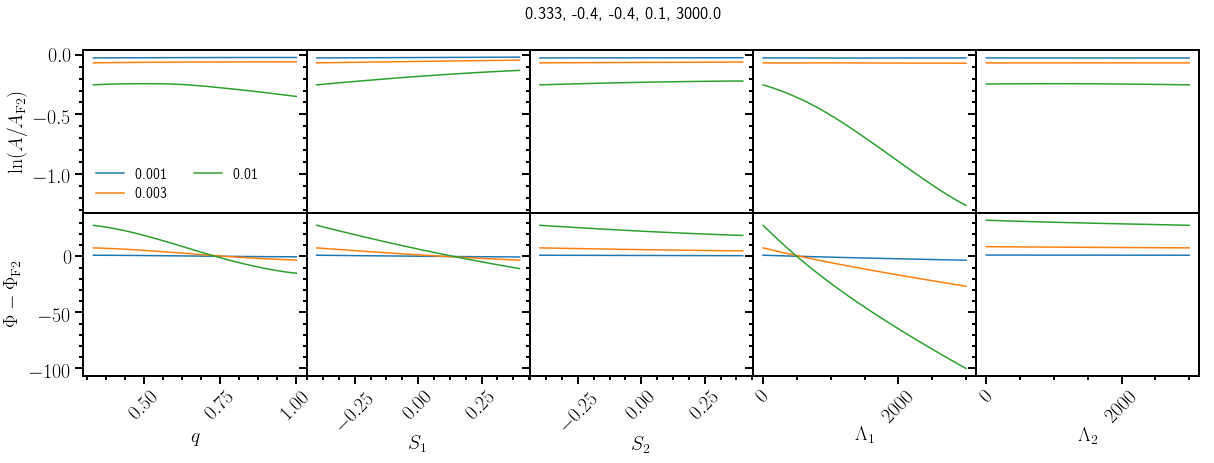

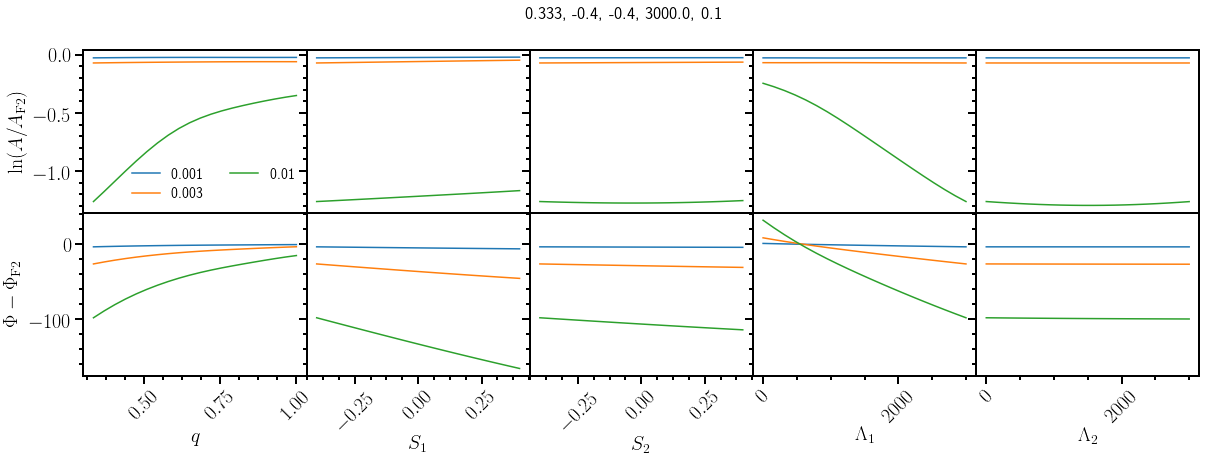

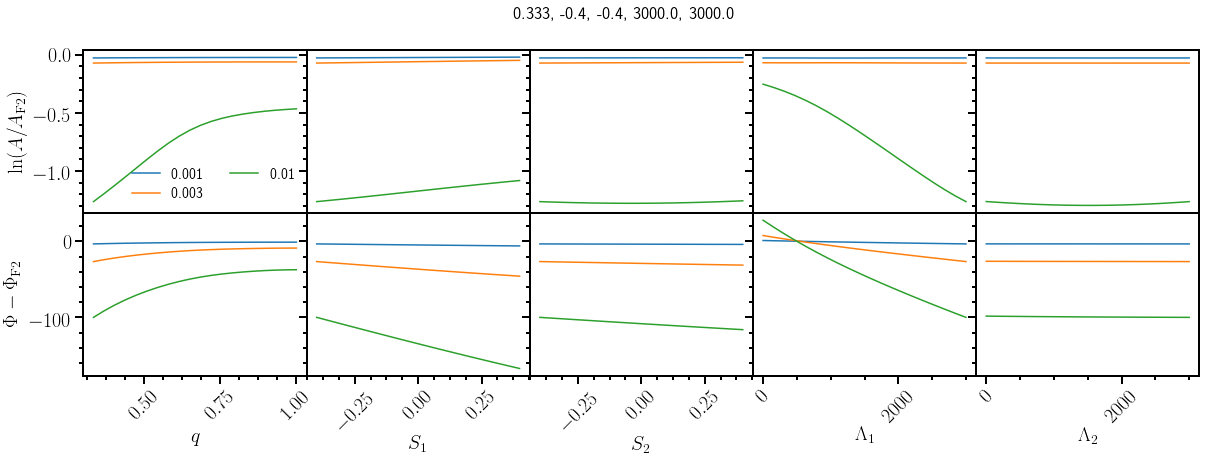

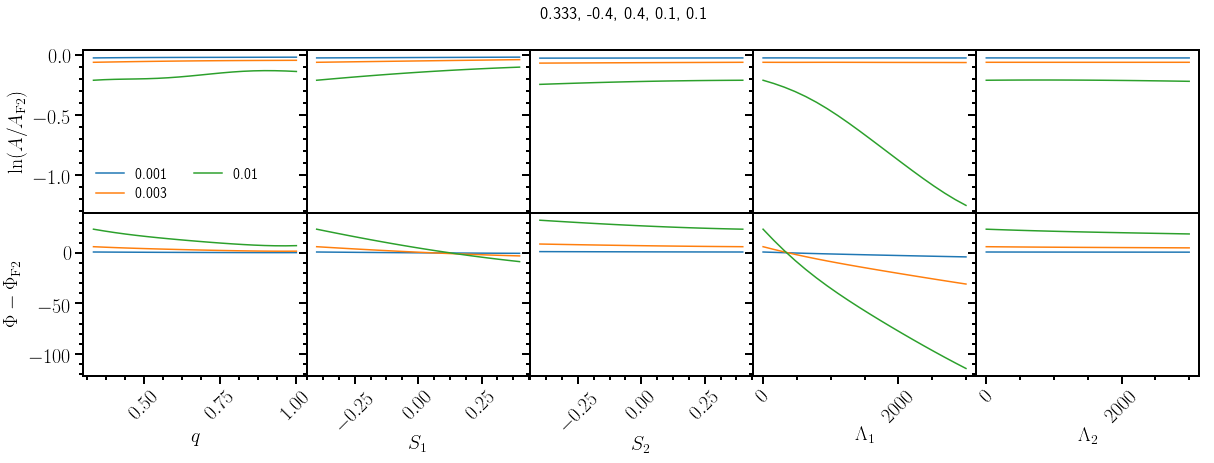

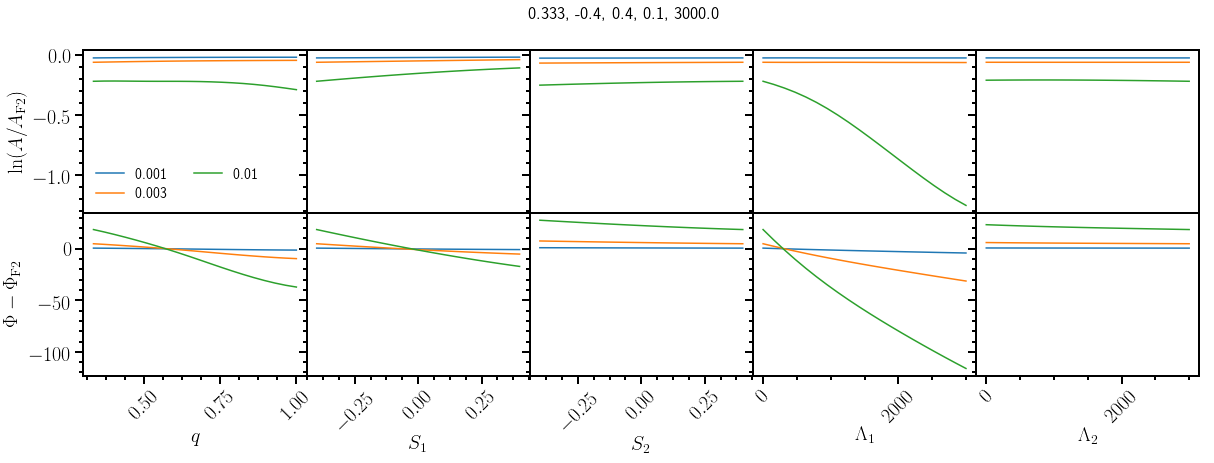

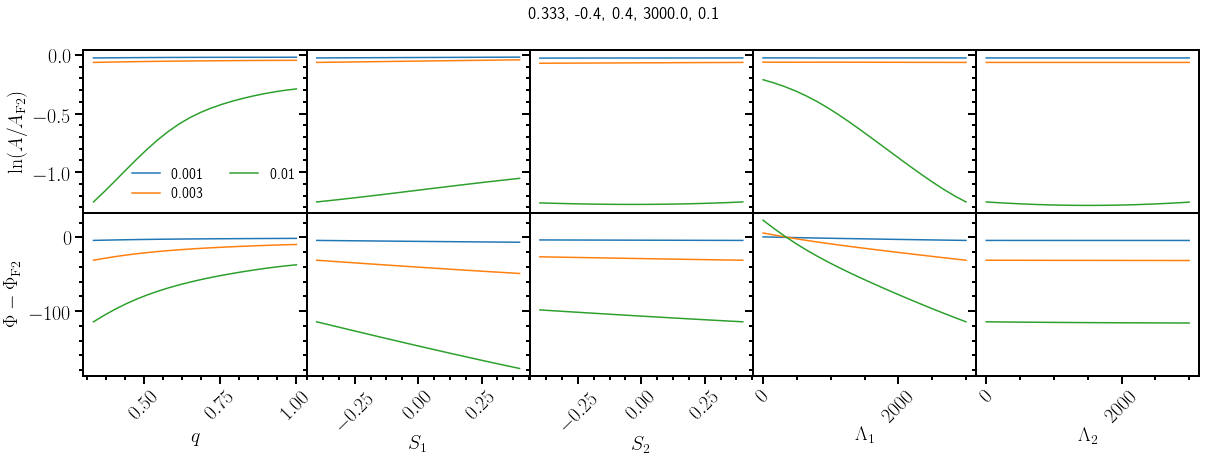

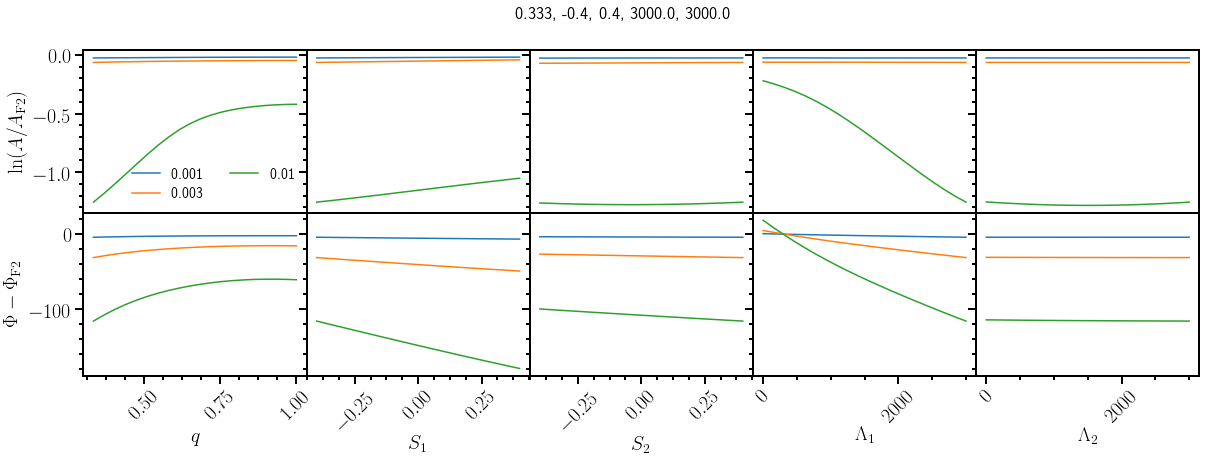

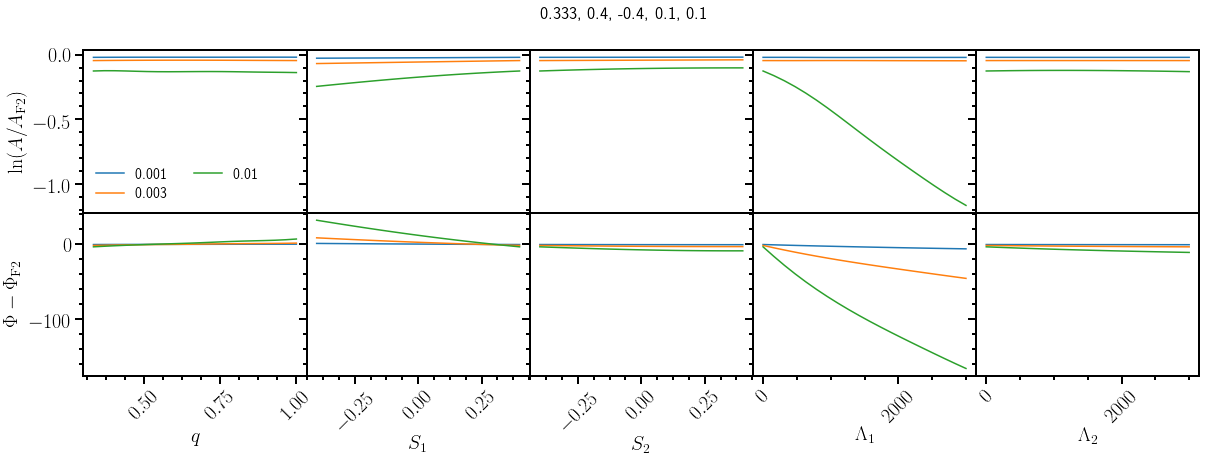

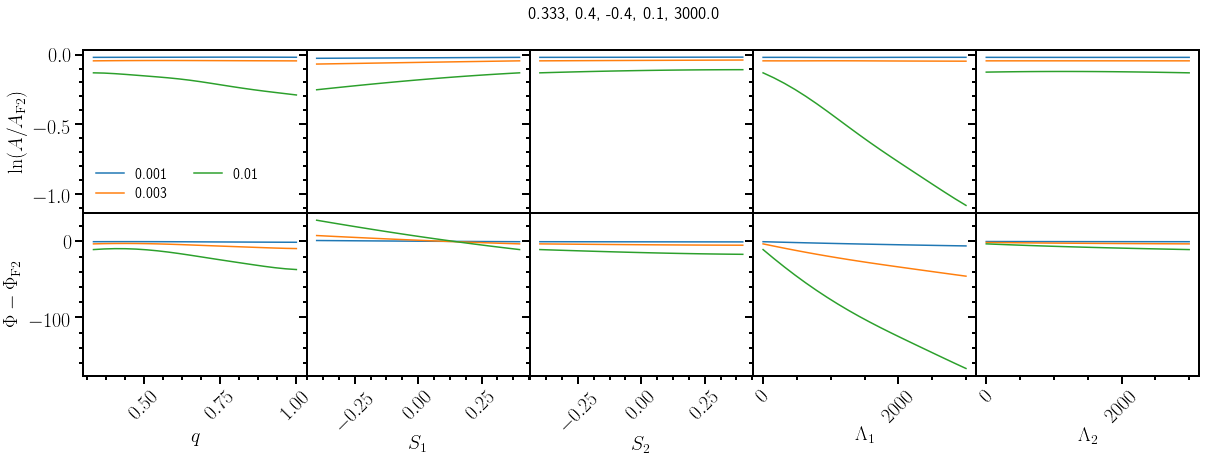

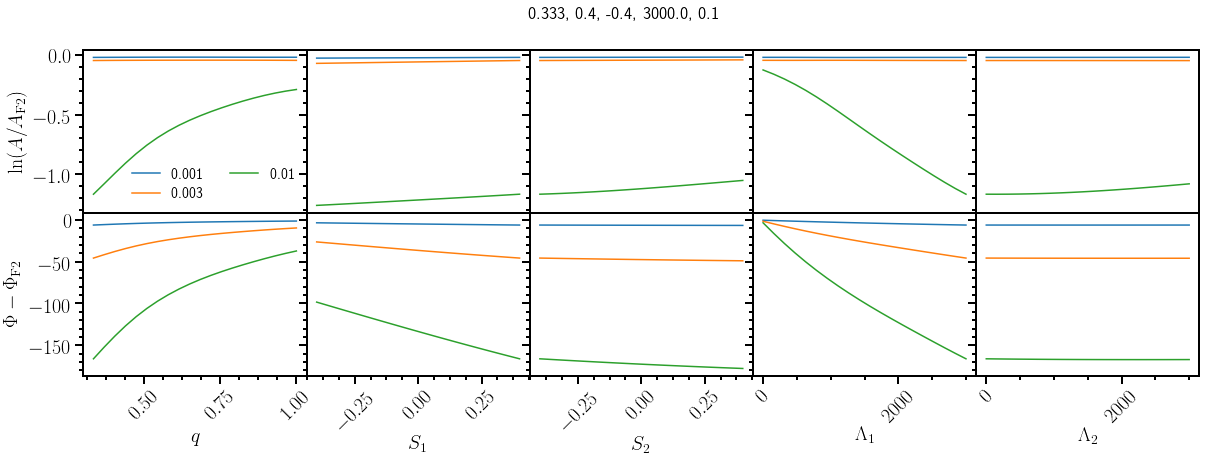

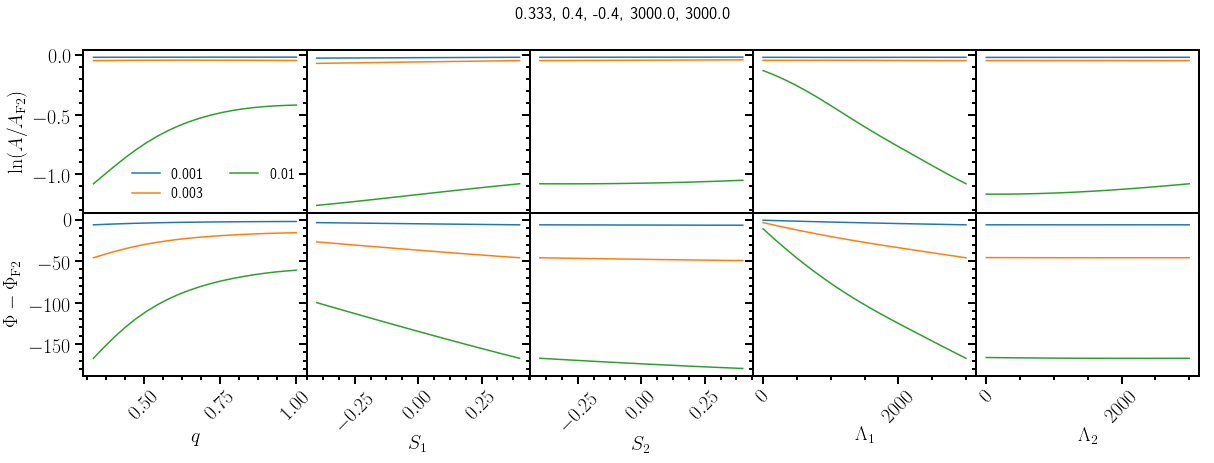

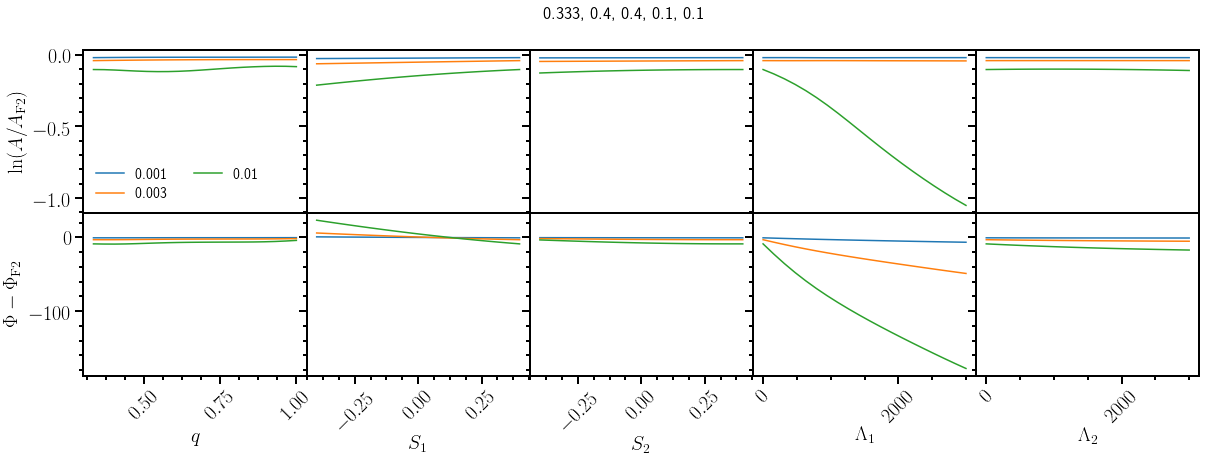

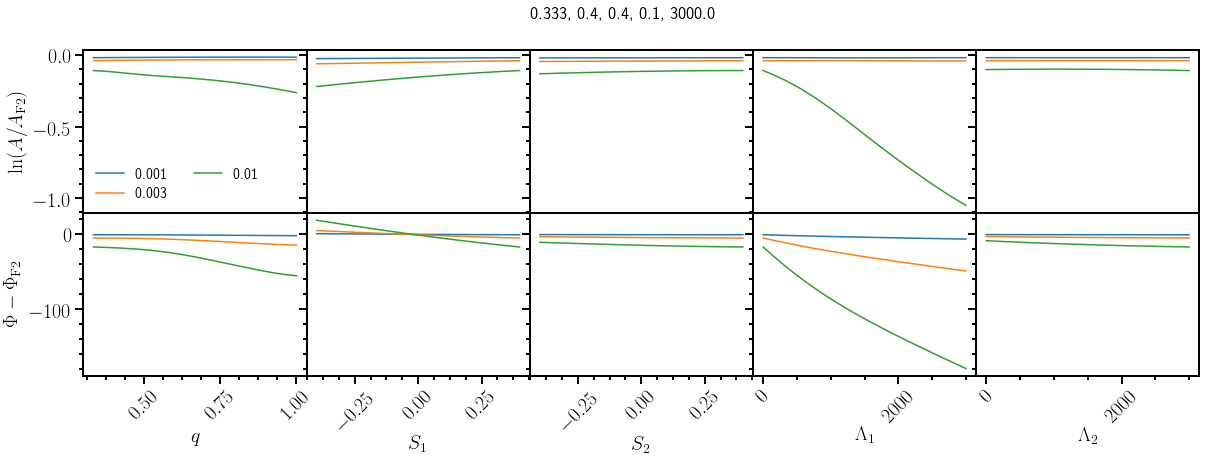

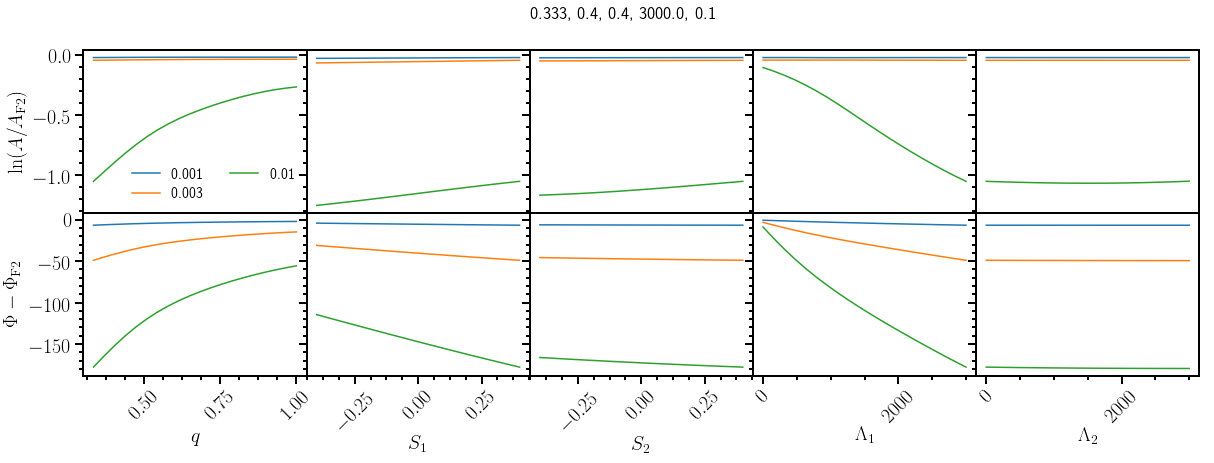

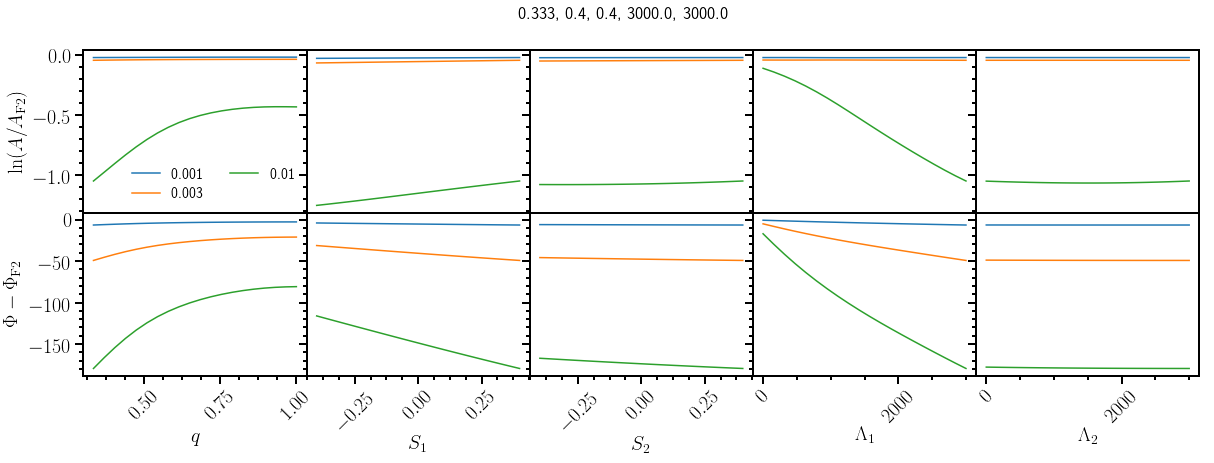

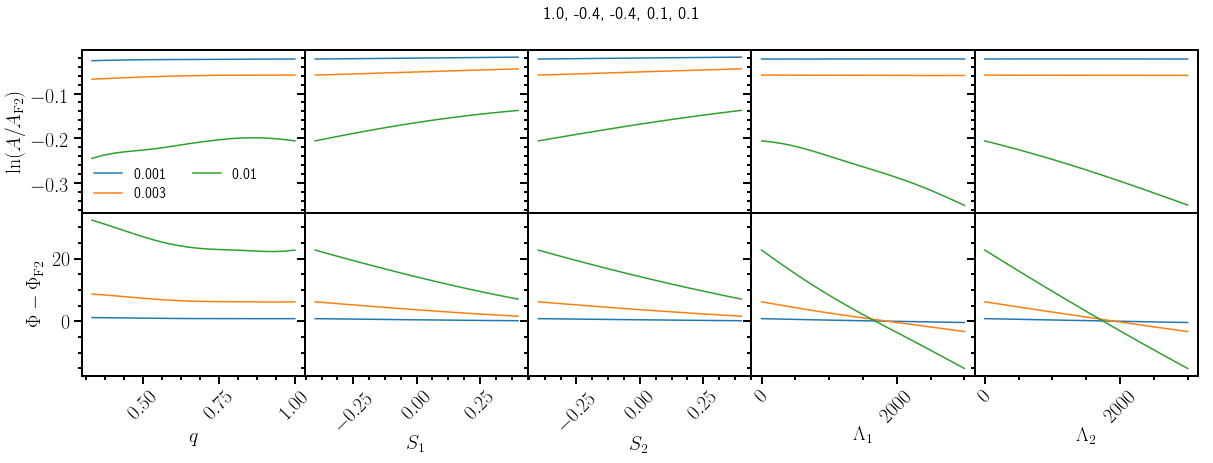

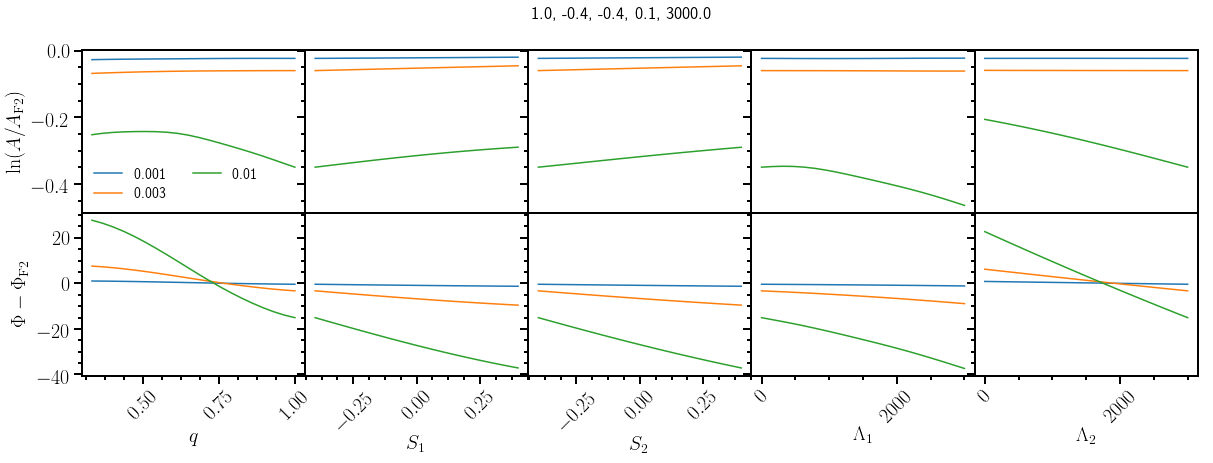

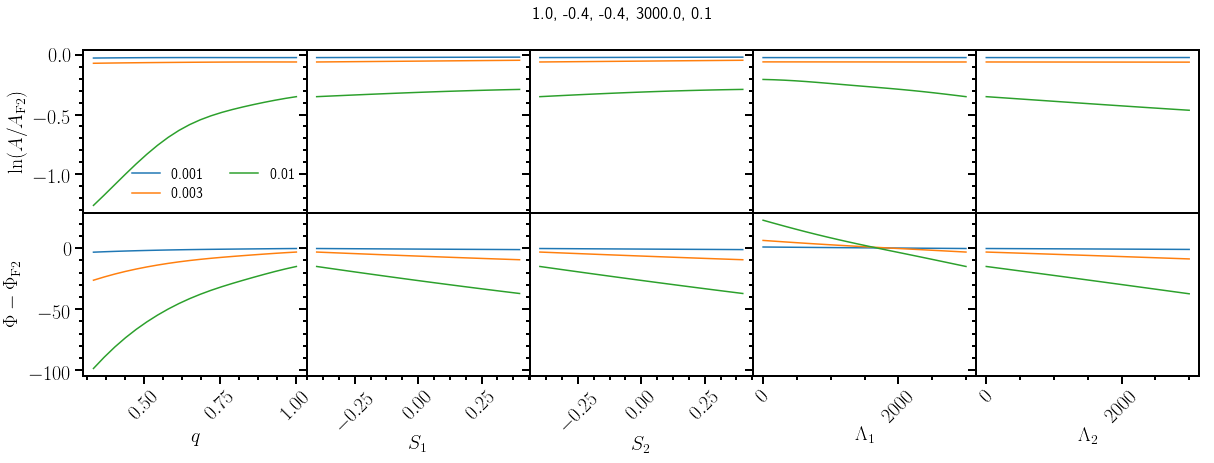

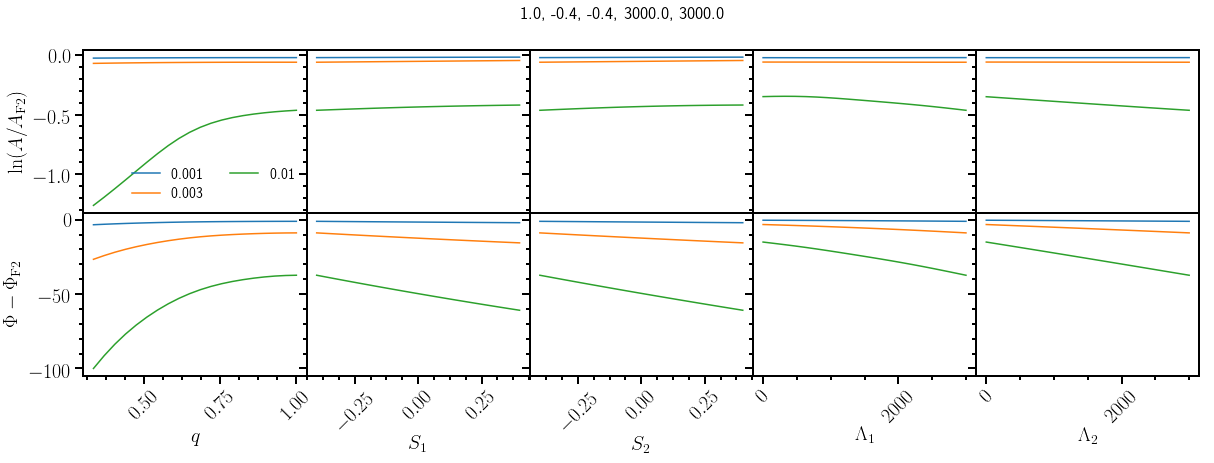

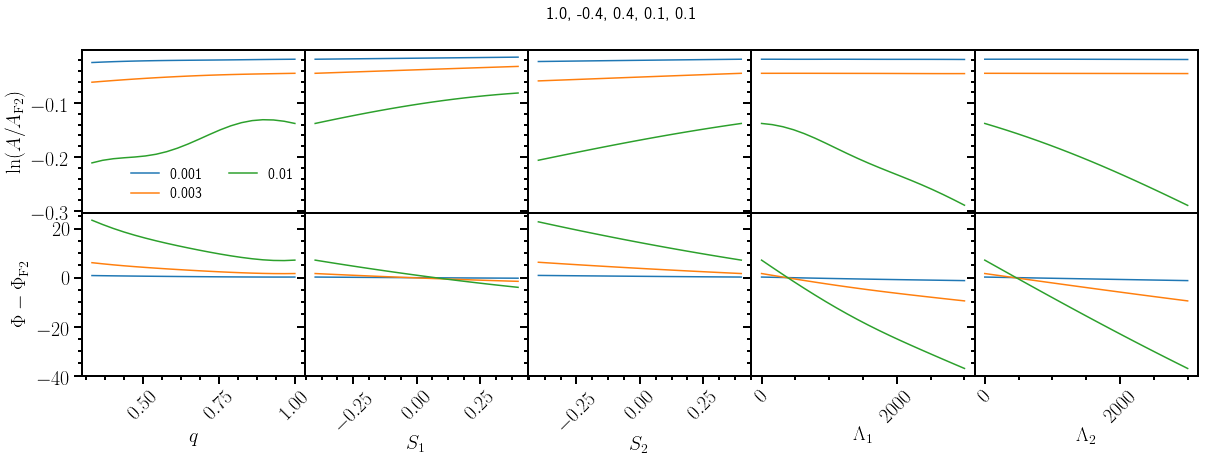

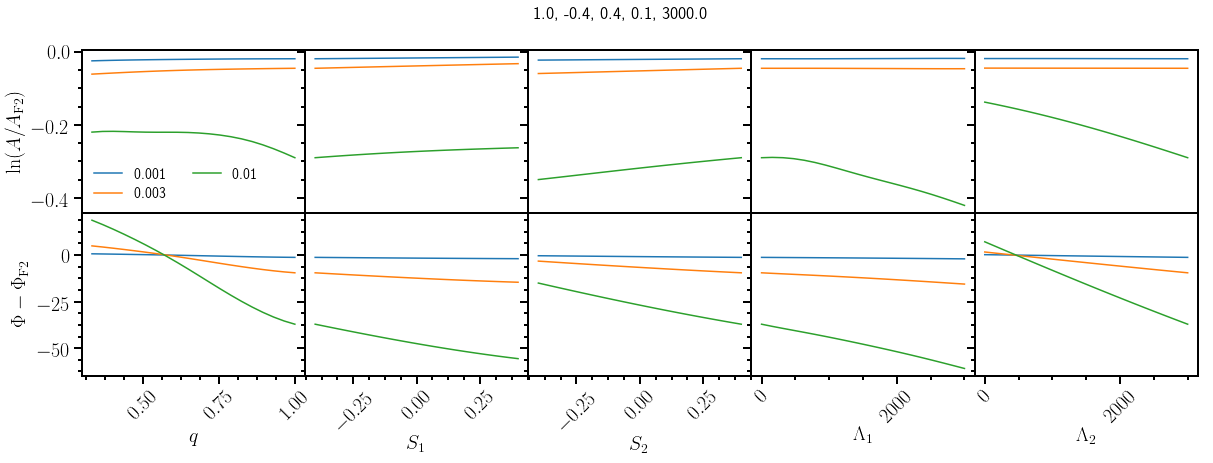

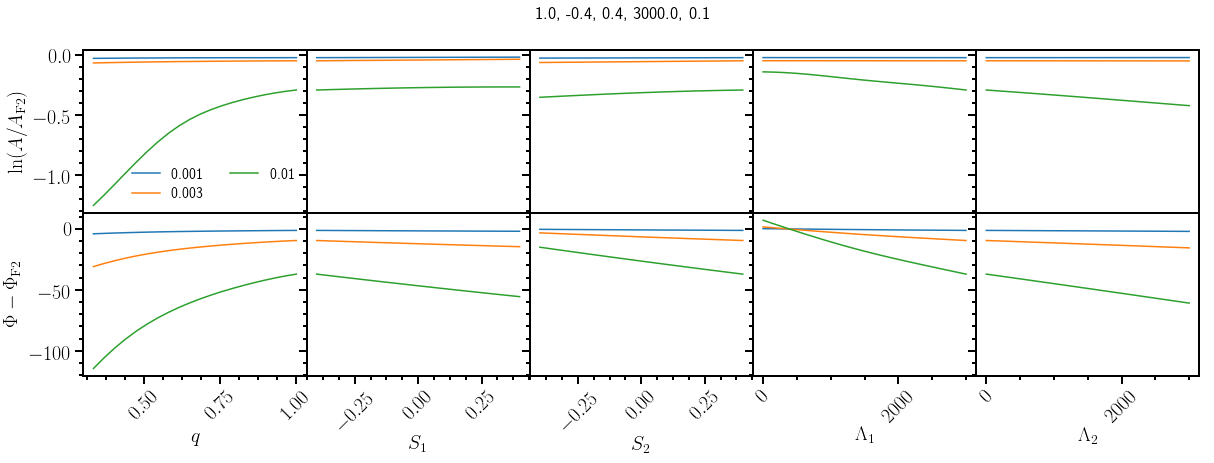

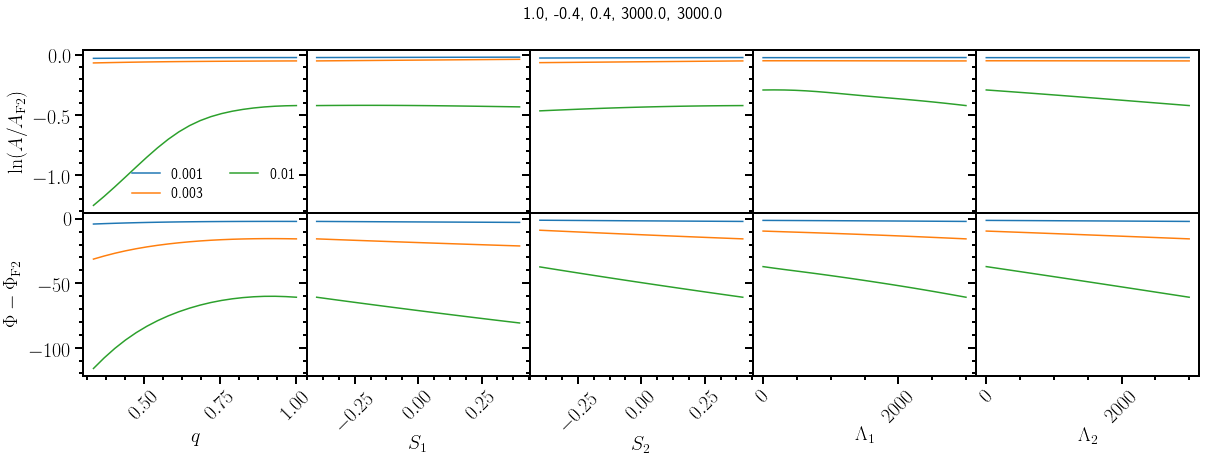

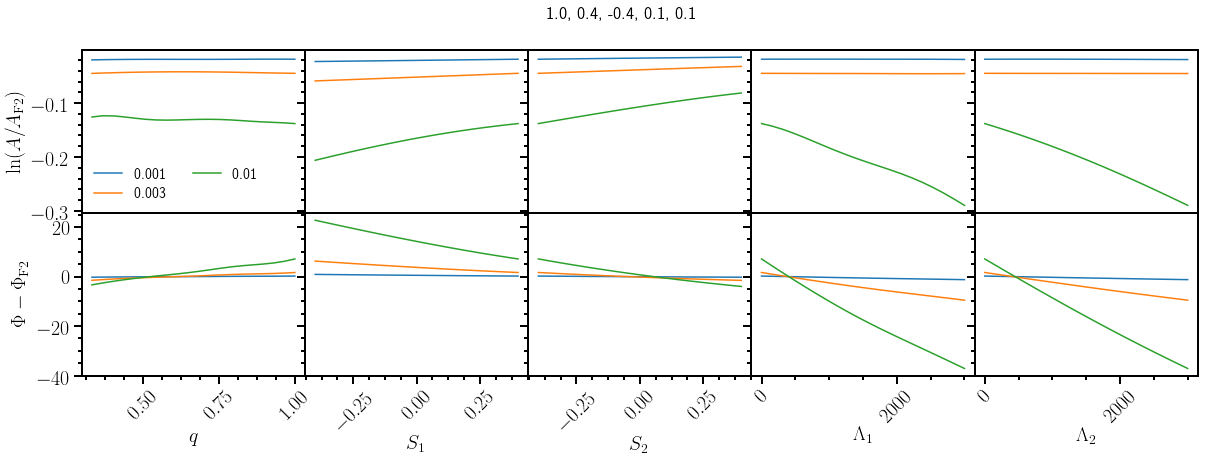

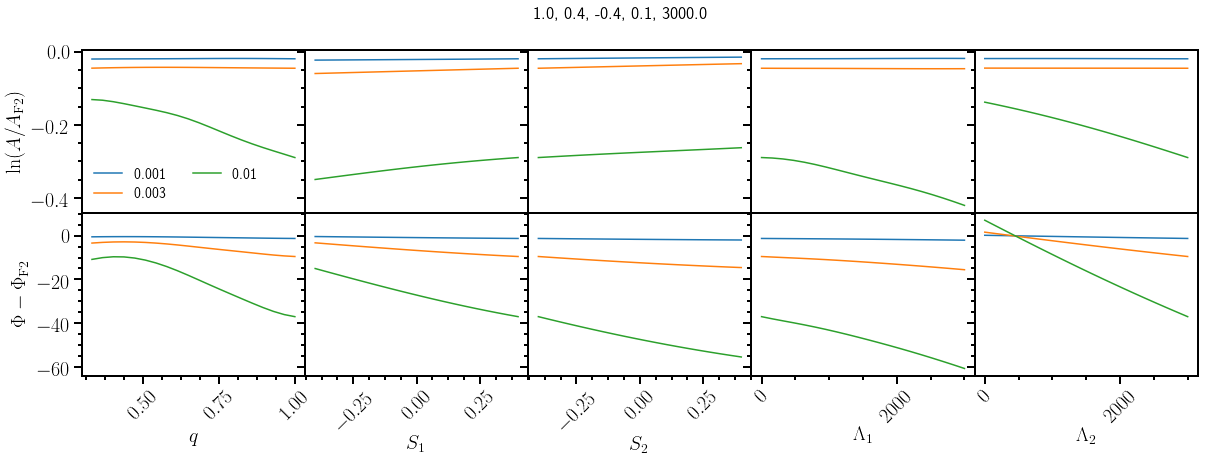

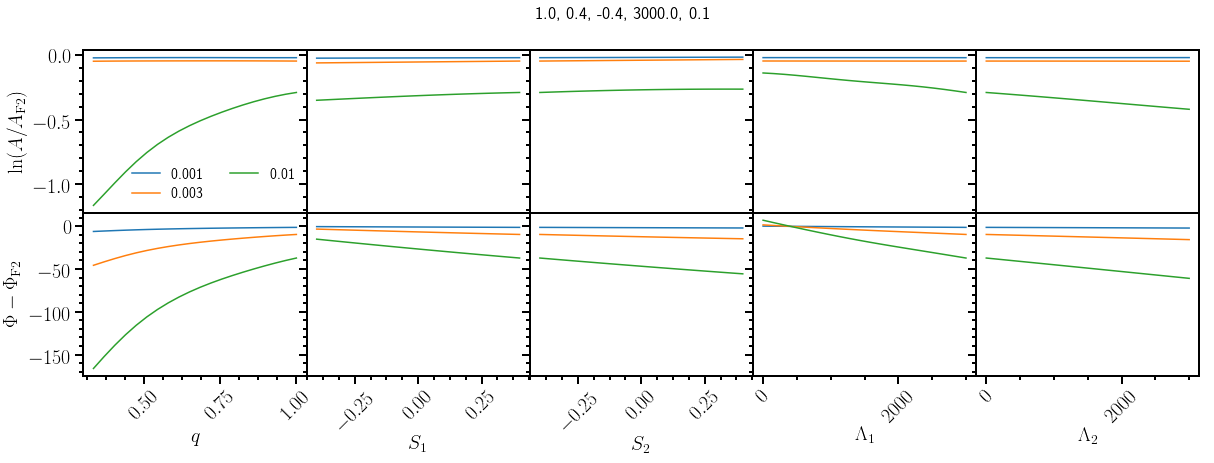

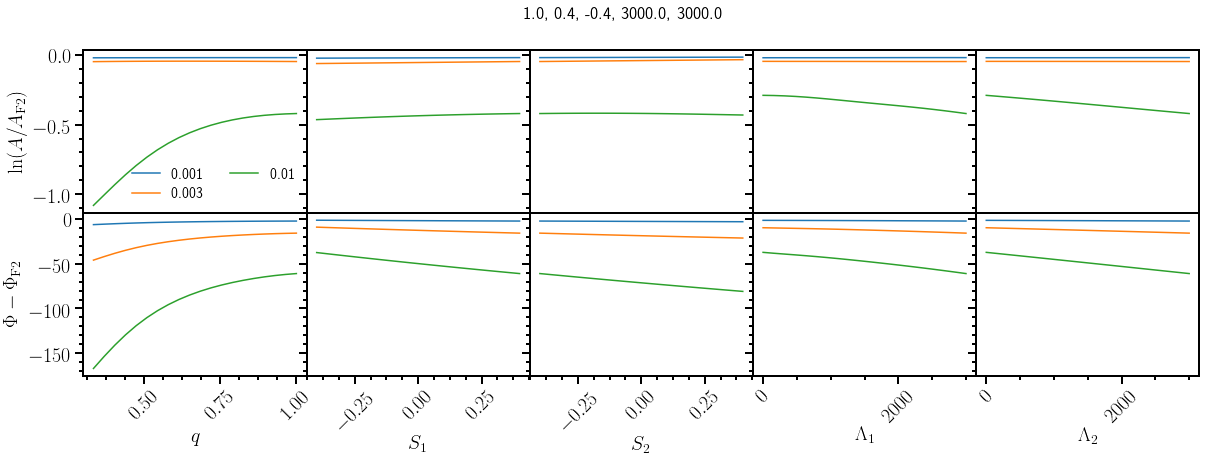

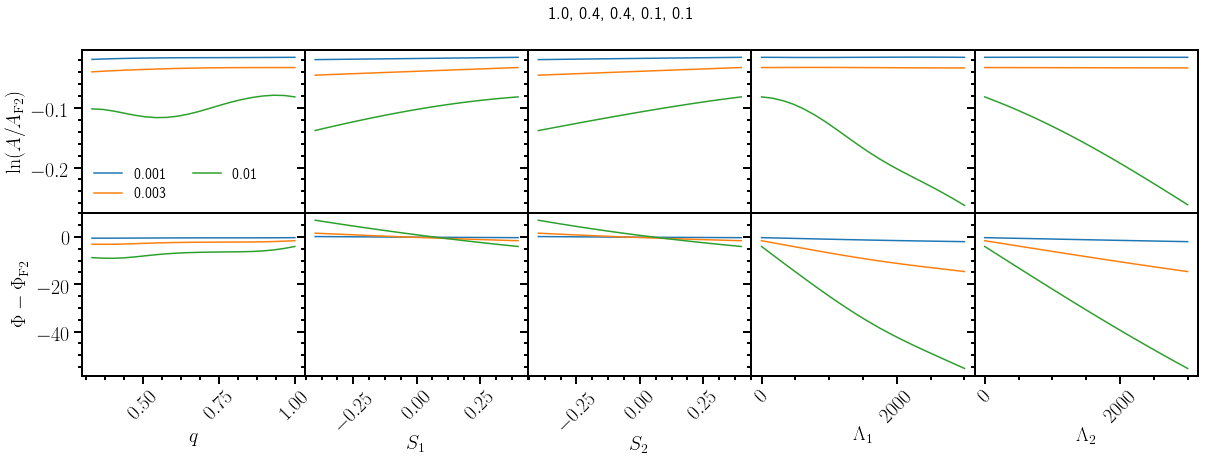

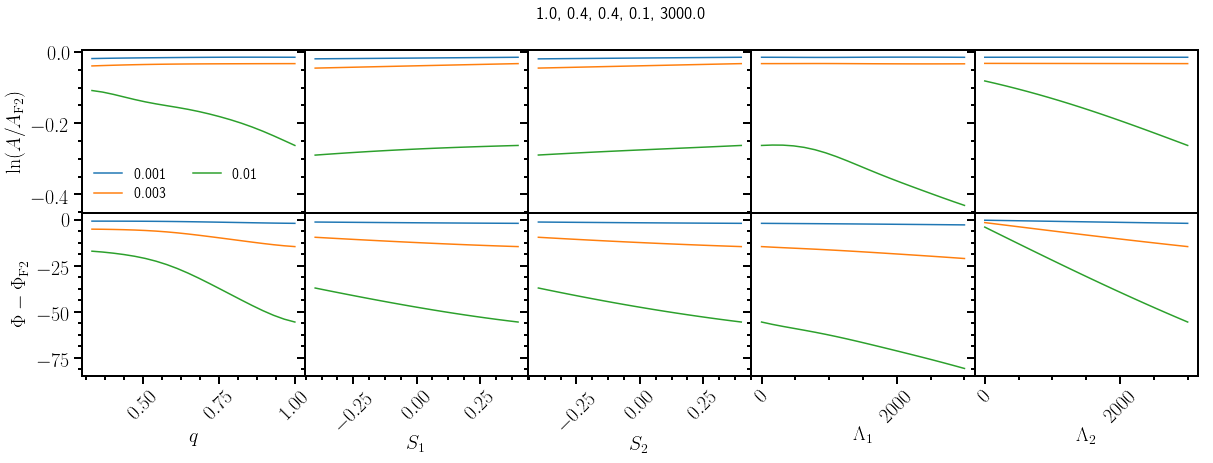

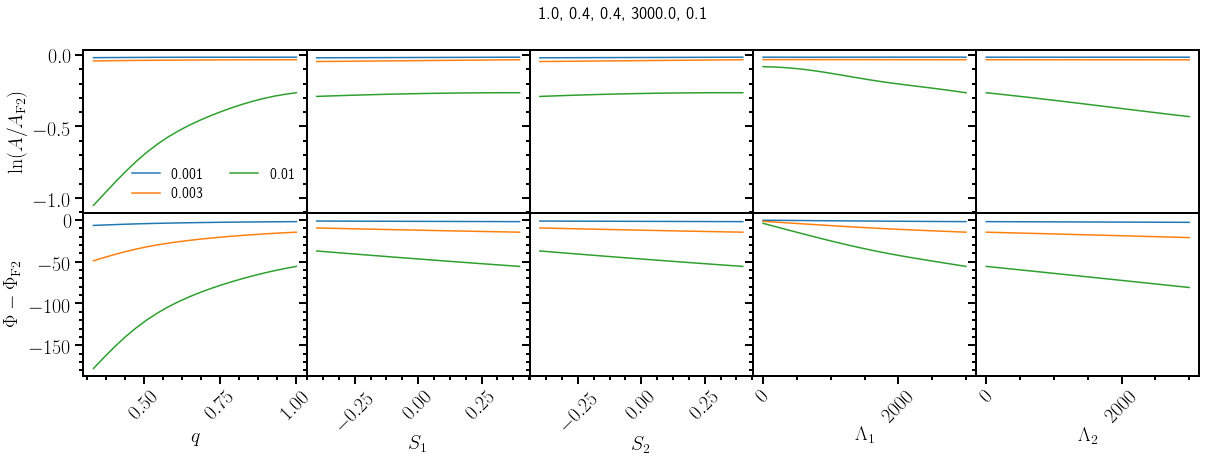

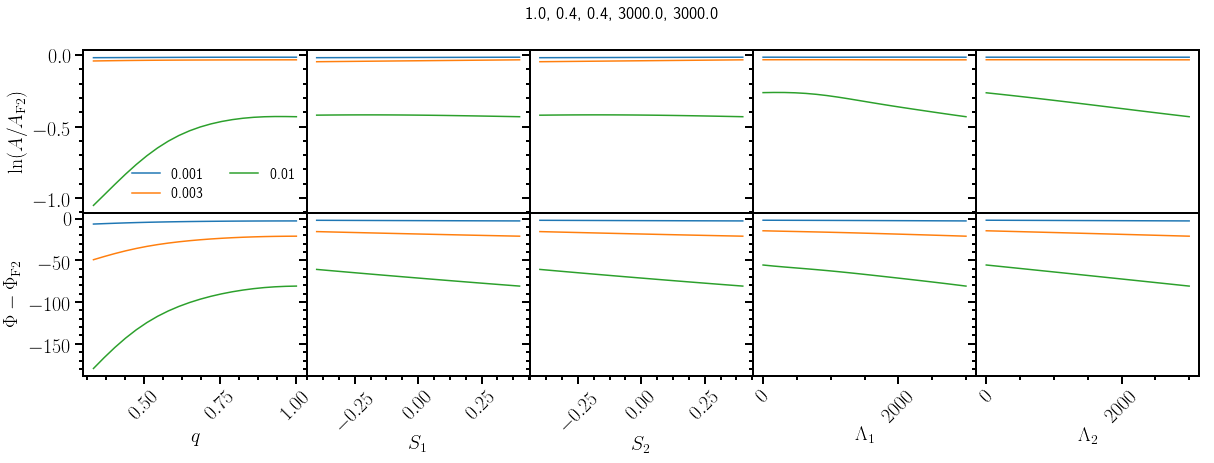

In [8]:
plots_on_corners()